In [1]:
import math
import os
import sys
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mxnet import gluon, autograd
from mxnet.gluon import nn, rnn


#let's use cpu for now
context = mx.cpu()

In [2]:
# module imports
from NLP.src.training import model, training, utils
from NLP.src.decoder import decoder
from NLP.src.pre_processing import pre_process
from NLP.src.generator import generator

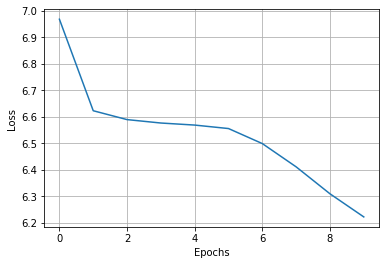

In [3]:
g = generator.Generator('sample_txt.txt', 10)

'he is thousand crumpets opens moon must there gave tree and way'

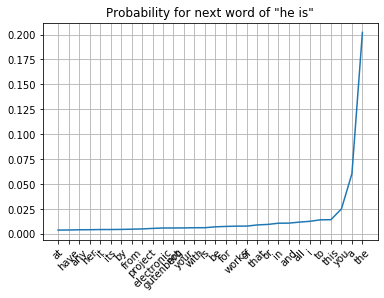

In [4]:
g.decode('he, is', output_length=10, get_next_probability=True, sample_count=10, get_next_probability_count=100000)

# Create a sequence
We don't want the sequence to be completely random, otherwise the RNN won't be able to learn much

When we got a word sequence, we need to map each unique word to an integer and the integer sequence will be fed into the neural net

In [5]:
seq, word_idx, idx_word = pre_process.pre_process('sample_txt.txt')

In [6]:
seq = mx.nd.array(seq, ctx=context)
vocab_size = len(word_idx)

In [8]:
word_idx['he']

1681

# DL portion

## Prepare for training

In [6]:
#model constants
num_embed = 5
num_hidden = 5
num_layers = 2

#training constants
args_lr = 1
args_epochs = 30
args_batch_size = 32

In [7]:
train_data = utils.batchify(seq, args_batch_size).as_in_context(context)

In [8]:
# define model and loss
# we do dropout=0 here to promote overfitting, on real data we might want a positive value
model_ = model.RNNModel(mode='gru', vocab_size=vocab_size, num_embed=num_embed, num_hidden=num_hidden,
                 num_layers=num_layers, dropout=0)
model_.collect_params().initialize(mx.init.Xavier(), ctx=context)
trainer = gluon.Trainer(model_.collect_params(), 'sgd',
                        {'learning_rate': args_lr, 'momentum': 0, 'wd': 0})
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [9]:
seed_list = ('he is').split(' ')
seed_seq = [word_idx[w] for w in seed_list]
seed_seq

[1119, 2322]

In [10]:
decoder_greedy = decoder.Decoder(model_, context=context)
seq_output, _ = decoder_greedy.decode(seed_seq, 10)
' '.join([idx_word[idx] for idx in seed_seq + seq_output])

'he is owns street quittee disk hwith slip each scattered exempt crâne'

# Finally, train the RNN

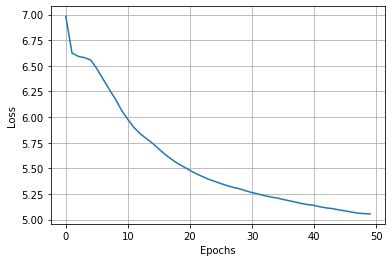

In [11]:
# finally train the model
trainer = gluon.Trainer(model_.collect_params(), 'sgd',
                        {'learning_rate': 1, 'wd': 0})
args_epochs = 50
training.train(train_data=train_data, model=model_, trainer=trainer, 
               loss=loss, args_epochs=args_epochs, args_batch_size=args_batch_size,
                context=context)

# Decoder, use the RNN we just learned to generate a sequence

## Here we just use a gready decoder, may do something fancier later

In [12]:
seed_list = ('he is').split(' ')
seed_seq = [word_idx[w] for w in seed_list]
seed_seq

[1119, 2322]

In [13]:
decoder_sample = decoder.Decoder(model_, mode='sample', n=100, context=context)
seq_output, ppensity = decoder_sample.decode(seed_seq, 20)
' '.join([idx_word[idx] for idx in seed_seq + seq_output])

'he is i like the terms of the project gutenberg my parrot slips and eye say may i ebooks in the knees'

([68.0,
  190.0,
  1555.0,
  591.0,
  190.0,
  2266.0,
  2664.0,
  20.0,
  1697.0,
  68.0,
  2322.0,
  2380.0,
  317.0,
  306.0,
  634.0,
  1543.0,
  1831.0,
  736.0,
  1783.0,
  1831.0],
 array([ 99.74609798,  90.8780756 ,  88.17329276, 112.91600556,
        104.09270112,  95.8361848 , 105.79364693,  83.10174009,
         92.71657984, 100.83550358,  56.42476609, 103.8442108 ,
        105.67458665, 126.71419716,  91.49340343, 102.96346939,
         92.01448384,  89.3662746 ,  82.09590137, 103.84195411,
         72.45012158, 108.89537326,  78.49749613,  96.77202383,
        106.15690291,  68.81878576,  97.65173209,  86.95805365,
         88.83314681,  85.23459461,  95.24586165,  82.54888964,
         91.64667338,  94.73533624,  67.51299915,  84.17085093,
         92.66416967, 101.57855392,  83.40234603, 112.11819243,
         94.1071189 ,  87.5457179 ,  88.86161828, 123.77259851,
         85.88793021,  98.03908908,  90.1364491 , 122.56117415,
         87.2266385 , 103.38158512,  93.6824

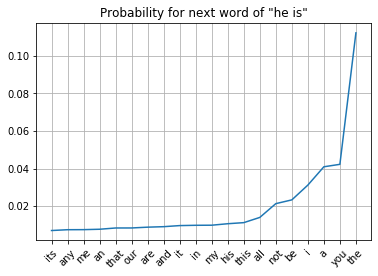

In [14]:
decoder_sample.decode(seed_seq, 20, word_idx=word_idx, idx_word=idx_word, get_next_probability=True, k=20)

# Auxiliary cells, don't read

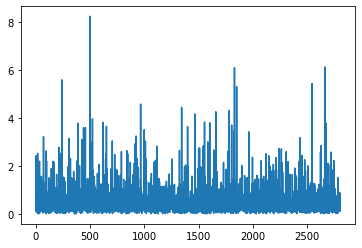

In [15]:
embed = model_.encoder.weight.data()
norms = (embed**2).sum(axis = 1)
norms = norms.asnumpy()
plt.plot(np.arange(vocab_size), norms)

In [16]:
norms[1171]

0.121032156

In [17]:
embed[877], norms[877]

(
 [ 0.38067982  0.12979907  0.32818657 -0.00353    -0.01201876]
 <NDArray 5 @cpu(0)>,
 0.26962826)

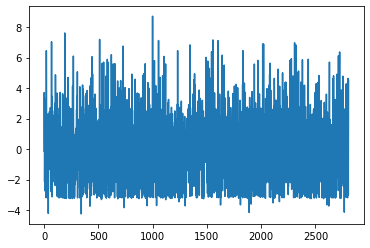

In [18]:
word = 'he'
ix = word_idx[word]

seed = mx.nd.array([[ix]])
seq_length = 50

hidden = model_.begin_state(func=mx.nd.zeros, batch_size=1, ctx=context)
output, hidden = model_(seed, hidden)
plt.plot(np.arange(vocab_size), output[0].asnumpy())

In [19]:
output = mx.nd.softmax(output[0]).asnumpy()

In [20]:
max_20_index = np.argsort(output)[-20:]

In [21]:
label = np.array([idx_word[i] for i in max_20_index])

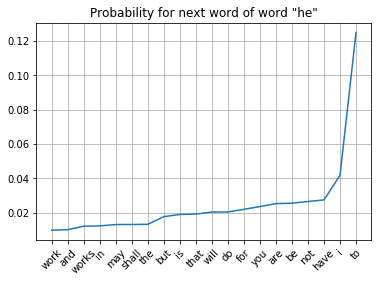

In [22]:
plt.plot(label, output[max_20_index])
plt.xticks(rotation=45)
plt.title('Probability for next word of word "{}"'.format(word))
plt.grid()